In [94]:
%matplotlib inline
import autograd.numpy as np
from autograd.numpy.linalg import inv, det
from functools import reduce
import autograd.numpy.random as npr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, gamma, invgamma 
from scipy.special import digamma

In [2]:
num_sequences = 50
time_length = 100
image_length = 20
generate_dataset_filename = './bouncingball'
dataset_filename = './bouncingball.npy'

## Generate Dataset

In [3]:
# def generate_video(image_length, time_length):
#     video = np.empty([image_length, time_length])
#     rand_pt = npr.randint(image_length)
#     rand_dir = npr.randint(2) ## 0 for downwards, 1 for upwards
#     for i in range(time_length):
#         one_hot = np.zeros(image_length)
#         one_hot[rand_pt] = 1.0
#         video[:, i] = one_hot
#         if rand_pt == 0:
#             rand_dir = 0
#         if rand_pt == 19:
#             rand_dir = 1

#         if rand_dir == 0:        
#             rand_pt += 1
#         else:
#             rand_pt -= 1
#     return video

# def generate_dataset(generate_dataset_filename, num_sequences, image_length, time_length):
#     video_lists = []
#     for i in range(num_sequences):
#         video = generate_video(image_length, time_length)
# #         plt.imshow(video, cmap='gray', vmin=0, vmax=1)
# #         plt.colorbar()
#         video_lists.append(video.reshape(1, image_length * time_length))
#     video_arrays = np.concatenate(video_lists, 0)
#     np.save(generate_dataset_filename, video_arrays)
#     return video_arrays

# video_arrays = generate_dataset(generate_dataset_filename, num_sequences, image_length, time_length)

## Load Dataset

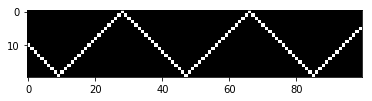

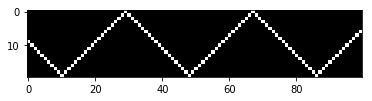

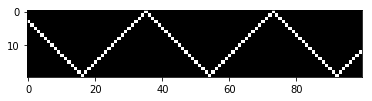

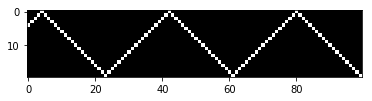

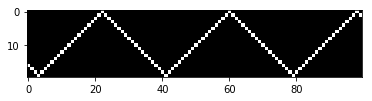

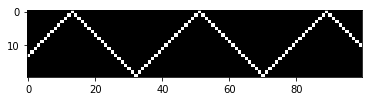

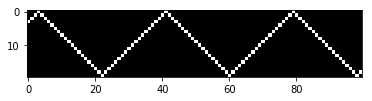

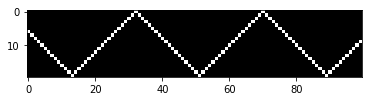

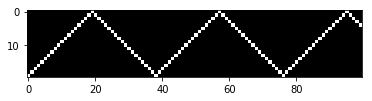

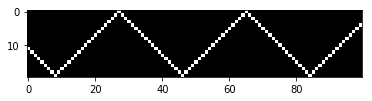

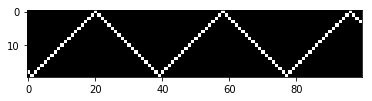

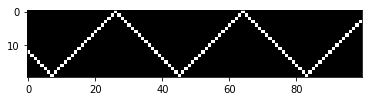

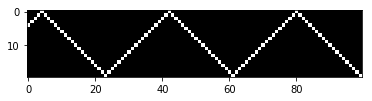

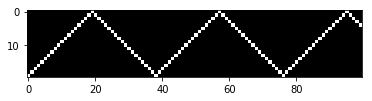

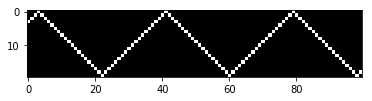

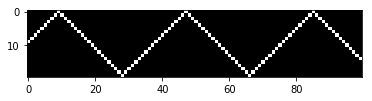

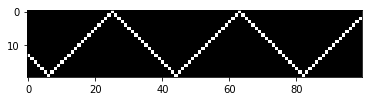

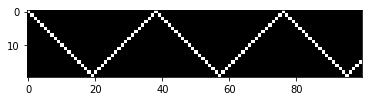

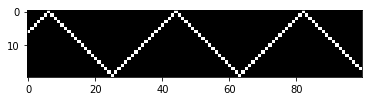

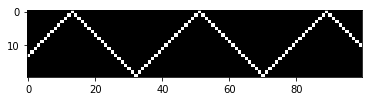

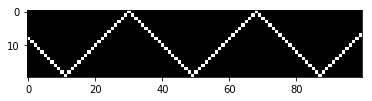

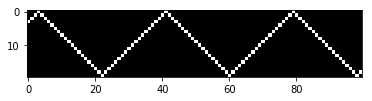

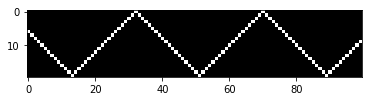

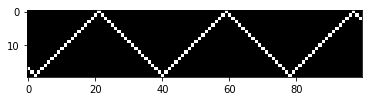

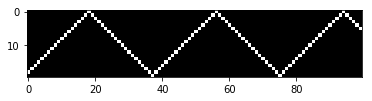

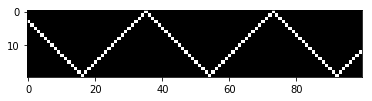

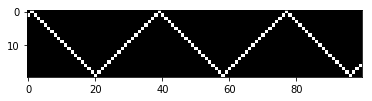

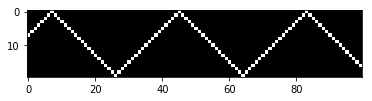

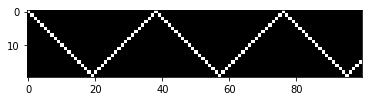

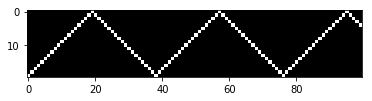

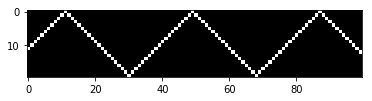

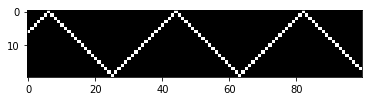

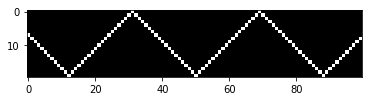

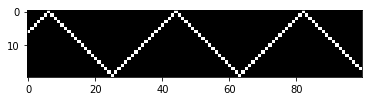

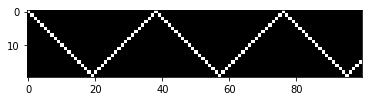

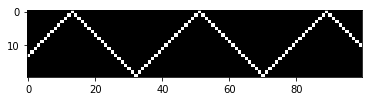

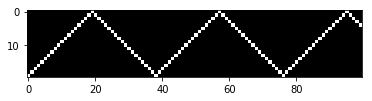

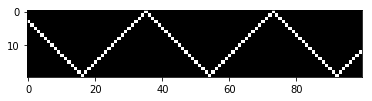

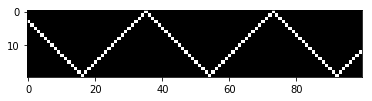

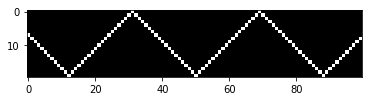

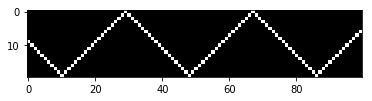

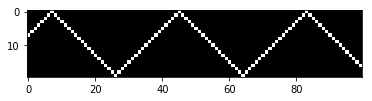

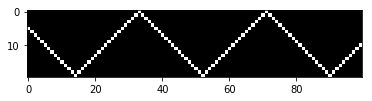

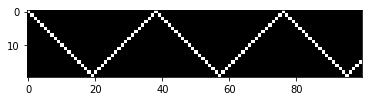

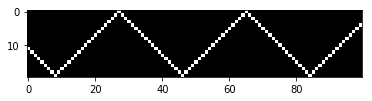

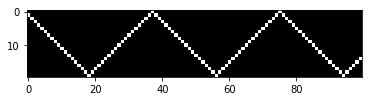

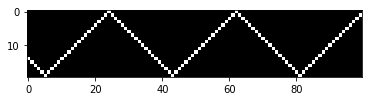

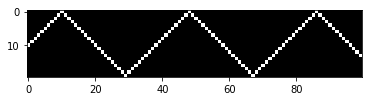

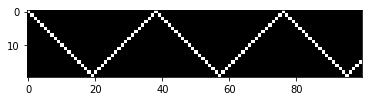

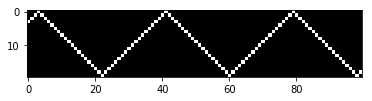

dataset size : 50, image length : 20, sequence length : 100


In [4]:
def load_data(dataset_filename, num_sequences, image_length, time_length):
    train_dataset = np.load(dataset_filename).reshape(num_sequences, image_length, time_length)
    for i in range(num_sequences):
        plt.imshow(train_dataset[i, :, :], cmap='gray', vmin=0, vmax=1)
        plt.show()
    x, y, z = train_dataset.shape
    print('dataset size : %d, image length : %d, sequence length : %d' % (x, y, z))
    return train_dataset

train_dataset = load_data(dataset_filename, num_sequences, image_length, time_length)

## Hyper-parameters

In [17]:
N = train_dataset.shape[1]
T = train_dataset.shape[2]
K = 8
## hyperprior for alpha, gamma
alpha_shape_0 = np.ones(K)
alpha_scale_0 = np.ones(K)

r_shape_0 = np.ones(K)
r_scale_0 = np.ones(K)

rho_shape_0 = np.ones(N)
rho_scale_0 = np.ones(N)

mu_x0_0_sigma_diag = np.ones(K)

sigma_x0_0_shape = np.ones(K)
sigma_x0_0_scale = np.ones(K)

## sample model parameters, hidden state priors
alpha = gamma.rvs(alpha_shape_0, alpha_scale_0)
r = gamma.rvs(r_shape_0, r_scale_0)
rho = gamma.rvs(rho_shape_0, rho_scale_0)
mu_x0 = multivariate_normal.rvs(np.zeros(K), np.diag(mu_x0_0_sigma_diag))
sigma_x0 = invgamma.rvs(sigma_x0_0_shape, sigma_x0_0_scale)

In [107]:

x_0 = multivariate_normal.rvs(mu_x0_0, np.diag(sigma_x0_0))
sigma_x0

array([3.57986105, 7.68371383, 1.50626997, 1.82230475, 3.58556501,
       1.782302  , 2.53197948, 1.85067985])

## Initial Hidden State Sufficient Statistics

In [60]:
## randomly initialize ss
W_A = npr.randn(K, K)
# G_A = 0
# M~ = 0
S_A = npr.randn(K, K)
W_C = npr.randn(K, K)
# G_C = 0
S_C = np.zeros((K, N))
## just take one video
video = train_dataset[0, :, :]
Y_hat = np.zeros((N, N))
for t in range(T):
    y = video[:, t]
    y.shape = (N, 1)
    Y_hat += np.dot(y, y.T)

## VBM Step

### 1. Infer variational distributions q(A), q(rho), q(C)

In [61]:
# q(B) = 0
# q(A) 
q_sigma_A = inv(np.diag(alpha) + W_A)
q_mu_A = np.dot(q_sigma_A, S_A) # each col is a mean vector

# q(C|rho)
sigma_C = inv(np.diag(r) + W_C)
G = Y_hat - np.dot(np.dot(S_C.T, sigma_C), S_C)
G_ss = np.diagonal(G)
#q(rho)
# q_sigma_C = (1 / rho_s)  * sigma_C
q_mu_C = np.dot(sigma_C, S_C) # each col is a mean vector

q_rho_shape  = rho_shape_0 + (T / 2) # each element is a shape parameter
q_rho_scale = rho_scale_0 + (G_ss / 2) # each element is a scale parameter

### 2. Compute expectation of natural parameters

In [74]:
E_A = np.dot(S_A.T, q_sigma_A)
E_ATA = np.dot(E_A.T, E_A) + K * q_sigma_A
E_rho_s = np.divide(q_rho_shape, q_rho_scale)
E_log_rho_s = digamma(q_rho_shape) - np.log(q_rho_scale)
E_R_inv = np.diag(E_rho_s)
E_C = np.dot(S_C.T, sigma_C)
E_R_inv_C = np.dot(E_R_inv, E_C)
E_CT_R_inv_C = np.dot(E_C.T, E_R_inv_C) + N * sigma_C

In [79]:
def eigen(a, B):
    return np.dot(np.dot(a.T, B), a)

## VBE Step

In [97]:
def forward_present(mu_last, sigma_last, yt):
    sigma_star_last = inv(inv(sigma_last) + E_ATA.T)
    sigma_xt = inv(np.eye(K) + E_CT_R_inv_C - eigen(E_A.T, sigma_star_last))
    mu_xt = np.dot(sigma_xt, \
                   np.dot(E_R_inv_C.T, yt) \
                   + reduce(np.dot, [E_A, sigma_star_last, inv(sigma_last), mu_last]))
    return mu_xt, sigma_xt, sigma_star_last

def forward_predictive_yt(mu_last, sigma_last, sigma_star_last, sigma_xt):
    yt_sigma = inv(E_R_inv - eigen(E_R_inv_C.T, sigma_xt))
    yt_mu = np.dot(yt_sigma, \
                  reduce(np.dot, [E_R_inv_C, sigma_xt, E_A, sigma_star_last, inv(sigma_last), mu_last]))
    return yt_mu, yt_sigma
def forward_marginal_yt(mu_last, sigma_last, sigma_star_last, mu_xt, sigma_xt, yt):
    return -(1 / 2) * (np.log(2*np.pi) - np.sum(E_log_rho_s) \
                       - np.log(det(reduce(np.dot, [inv(sigma_last), sigma_star_last, sigma_xt]))) + eigen(mu_last, inv(sigma_last)) \
                       - eigen(mu_xt, inv(sigma_xt)) + eigen(yt, E_R_inv) \
                       - eigen(np.dot(inv(sigma_last), mu_last), sigma_star_last))

### 1. Forward recursion

In [100]:
def forward(mu_x0, sigma_x0):
    for t in range(T):
        yt = video[:, t]
        yt.shape = (N, 1)
        if t == 0:
            mu_last = mu_x0
            sigma_last = sigma_x0
            mu_xt, sigma_xt, sigma_star_last = forward_present(mu_last, sigma_last, yt)
            yt_mu, yt_sigma = forward_predictive_yt(mu_last, sigma_last, sigma_star_last, sigma_xt)
#             log_yt = forward_marginal_yt(mu_last, sigma_last, sigma_star_last, mu_xt, sigma_xt, yt)
            
        else:
            mu_last = mu_xt
            sigma_last = sigma_xt
            mu_xt, sigma_xt, sigma_star_last = forward_present(mu_last, sigma_last, yt)
            yt_mu, yt_sigma = forward_predictive_yt(mu_last, sigma_last, sigma_star_last, sigma_xt)
#             log_yt = forward_marginal_yt(mu_last, sigma_last, sigma_star_last, mu_xt, sigma_xt, yt)
forward(mu_x0, np.diag(sigma_x0))

### 2. Backward recursion

In [112]:
def backward_ssm(psi_t_inv, eta_t, yt):
    psi_star_t = inv(np.eye(K) + E_CT_R_inv_C + psi_t_inv)
    psi_next = inv(E_ATA - eigen(E_A, psi_star_t))
    term0 = np.dot(E_R_inv_C.T, yt) + np.dot(psi_t_inv, eta_t) 
    eta_next = reduce(np.dot, [psi_next, E_A.T, psi_star_t, term0])
    return psi_next, eta_next

In [116]:
def backward(psi_T_inv, eta_T):
    for t in range(T, 0, -1):
        yt = video[:, t-1]
        yt.shape = (N, 1)
        if t == T:
            psi_t_inv = psi_T_inv
            eta_t = eta_T
            psi_next, eta_next = backward_ssm(psi_t_inv, eta_t, yt)
            psi_next_inv = inv(psi_next)
        else:
            psi_t_inv = psi_next_inv
            eta_t = eta_next
            psi_next, eta_next = backward_ssm(psi_t_inv, eta_t, yt)
            psi_next_inv = inv(psi_next)
         

In [115]:
psi_T_inv = np.zeros((K, K))
eta_T = np.zeros((K, 1))
backward(psi_T_inv, eta_T)

### 3. Update mean and cov

In [ ]:
def update_marginals():
    for t in range(0, T+1):
        Gamma_tt = inv(sigma_xt + psi_)
        omega_t = 

### 4. Update HSS